In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import manifold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Settings
Define an output folder containing saved results from run_ensemble.py

In [82]:
ensemble_model_output_folder = 'ensemble_inter_cola_test'

agreement_metrics = [['Lime_agreement'],
                     ['Shap_agreement'],
                     ['Attention_agreement'],
                     ['Integrated_Grad_agreement'],
                     #['Lime_agreement', 'Integrated_Grad_agreement'],
                     #['Lime_agreement', 'Attention_agreement'],
                     #['Lime_agreement', 'Shap_agreement'],
                     #['Shap_agreement', 'Attention_agreement'],
                     #['Shap_agreement', 'Integrated_Grad_agreement'],
                     #['Attention_agreement', 'Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Shap_agreement', 'Attention_agreement', 'Integrated_Grad_agreement']
                    ]

### Generate performance metrics
(will calculate interpretability weighted ensemble predictions for each item in agreement_metrics)

In [83]:
#df = pd.read_csv(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.csv')
df = pd.read_pickle(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.pkl')
#df.head(2)

In [84]:
### individual model predictions ###
models = sorted(list(set(df['Model_id'].values)))

all_ensemble_preds = df[df['Model_id'] == models[0]][['Test_example', 'True Label', 'Tokens_unified']]

for m in models:
    all_ensemble_preds[m] = df[df['Model_id'] == m]['Probability for Hate'].values

### majority vote baseline ###
all_ensemble_preds['majority_baseline'] = all_ensemble_preds[models].median(axis=1)

### straight avg baseline ###
all_ensemble_preds['straight_avg_baseline'] = all_ensemble_preds[models].mean(axis=1)


### interpretability weighted predictions ###

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=temp.loc[x.index, "agreement"])

for mt in agreement_metrics:
    
    temp = df[['Test_example', 'Model_id', 'Probability for Hate']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
    modal_vote = temp.loc[temp.groupby("Test_example")["agreement"].idxmax()]['Probability for Hate'].values
    wtd_vote = temp.groupby(["Test_example"]).agg(wtd_vote=("Probability for Hate", wm)).wtd_vote.values
    all_ensemble_preds[f"{'_'.join(mt)}_modal_vote"] = modal_vote
    all_ensemble_preds[f"{'_'.join(mt)}_wtd_avg"] = wtd_vote

In [104]:
# Calculate ensemble metrics
def calc_metrics(all_ensemble_preds):

    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []

    for ensemble_pred in all_ensemble_preds.columns[3:]:
            y_true = np.array(all_ensemble_preds['True Label'])
            y_pred = np.array(all_ensemble_preds[ensemble_pred] >= 0.5)
            tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
            precisions.append(tp / (tp + fp))
            recalls.append(tp / (tp + fn))
            f1_scores.append(2 * tp / (2*tp + fp + fn))
            accuracies.append((tp + tn) / (tp + tn + fp + fn))


    metrics = pd.DataFrame({'model': all_ensemble_preds.columns[3:],
                            'precision': precisions,
                            'recall': recalls,
                            'f1_score': f1_scores,
                            'accuracy': accuracies})
    return metrics

metrics = calc_metrics(all_ensemble_preds)
metrics

,model,precision,recall,f1_score,accuracy
0,cola_bert_medium_rand_1_test,0.730853,0.943503,0.823674,0.722868
1,cola_bert_medium_rand_2_test,0.789744,0.870056,0.827957,0.751938
2,cola_bert_medium_rand_3_test,0.772727,0.912429,0.836788,0.755814
3,cola_bert_rand_1_test,0.825193,0.906780,0.864065,0.804264
4,cola_bert_rand_2_test,0.802850,0.954802,0.872258,0.808140
5,cola_bert_rand_3_test,0.840000,0.889831,0.864198,0.808140
6,cola_roberta_rand_1_test,0.823821,0.937853,0.877147,0.819767
7,cola_roberta_rand_2_test,0.686047,1.000000,0.813793,0.686047
8,cola_roberta_rand_3_test,0.686047,1.000000,0.813793,0.686047
9,majority_baseline,0.773973,0.957627,0.856061,0.779070


In [110]:
# Calculate confidence intervals around metrics (using bootstrapping)
num_bootstraps = 10000

bootstrap_metrics = pd.DataFrame({'model': pd.Series(dtype='str'),
                                  'precision': pd.Series(dtype='str'),
                                  'recall': pd.Series(dtype='str'),
                                  'f1_score': pd.Series(dtype='str'),
                                  'accuracy': pd.Series(dtype='str')})

for i in range(num_bootstraps):
    
    all_ensemble_preds_bootstrap = all_ensemble_preds.sample(n=all_ensemble_preds.shape[0],
                                                             replace=True, random_state=i)
    bootstrap_metrics = pd.concat([bootstrap_metrics,
                                   calc_metrics(all_ensemble_preds_bootstrap)])

# calculate std dev of each metric (based on empirical bootstrap samples)
bootstrap_metrics = bootstrap_metrics.groupby('model').agg(precision_std = ('precision', np.std),
                                                           recall_std = ('recall', np.std),
                                                           f1_score_std = ('f1_score', np.std),
                                                           accuracy_std = ('accuracy', np.std)).reset_index()

# join confidence intervals to original metrics
final_metrics = pd.merge(left = metrics, right = bootstrap_metrics, on = 'model')
final_metrics

,model,precision,recall,f1_score,accuracy,precision_std,recall_std,f1_score_std,accuracy_std
0,cola_bert_medium_rand_1_test,0.730853,0.943503,0.823674,0.722868,0.020633,0.012305,0.014481,0.019612
1,cola_bert_medium_rand_2_test,0.789744,0.870056,0.827957,0.751938,0.020537,0.018160,0.014961,0.018964
2,cola_bert_medium_rand_3_test,0.772727,0.912429,0.836788,0.755814,0.020334,0.015145,0.014230,0.018736
3,cola_bert_rand_1_test,0.825193,0.906780,0.864065,0.804264,0.019189,0.015377,0.013363,0.017396
4,cola_bert_rand_2_test,0.802850,0.954802,0.872258,0.808140,0.019300,0.011052,0.012666,0.017242
5,cola_bert_rand_3_test,0.840000,0.889831,0.864198,0.808140,0.018796,0.016778,0.013452,0.017207
6,cola_roberta_rand_1_test,0.823821,0.937853,0.877147,0.819767,0.018839,0.012806,0.012535,0.016767
7,cola_roberta_rand_2_test,0.686047,1.000000,0.813793,0.686047,0.020328,0.000000,0.014317,0.020328
8,cola_roberta_rand_3_test,0.686047,1.000000,0.813793,0.686047,0.020328,0.000000,0.014317,0.020328
9,majority_baseline,0.773973,0.957627,0.856061,0.779070,0.019842,0.010740,0.013261,0.018134


In [ ]:
# model_names_for_plot = ['B-medium_1', 'B-medium_2', 'B-medium_3',
#        'Bert_1', 'Bert_2', 'Bert_3', 'Roberta_1', 'Roberta_2', 'Roberta_3',
#         # 'weight avg nn',
#        'majority_baseline',
#        'straight_avg_baseline',
#        'Lime_model_vote', 'Lime_wtd_avg',
#        'Shap_modal_vote', 'Shap_wtd_avg',
#        'Attn_modal_vote', 'Attn_wtd_avg',
#        'IntGr_modal_vote',
#        'IntGr_wtd_avg',
#        'Lime_IntGr_modal_vote',
#        'Lime_IntGr_wtd_avg',
#        'Lime_Shap_Attn_IntGr_modal_vote',
#        'Lime_Shap_Attn_IntGr_wtd_avg']

# fig, axs = plt.subplots(figsize = (20,6))
# axs.bar(x = model_names_for_plot, height = metrics['f1_score'])
# #axs.set_ylabel('ylabel', fontsize=16)
# axs.tick_params(size=10, rotation=90)
# #fig.savefig('yourfilename.png')).

### Quick plot to see what the average agreement (and spread) is across test examples

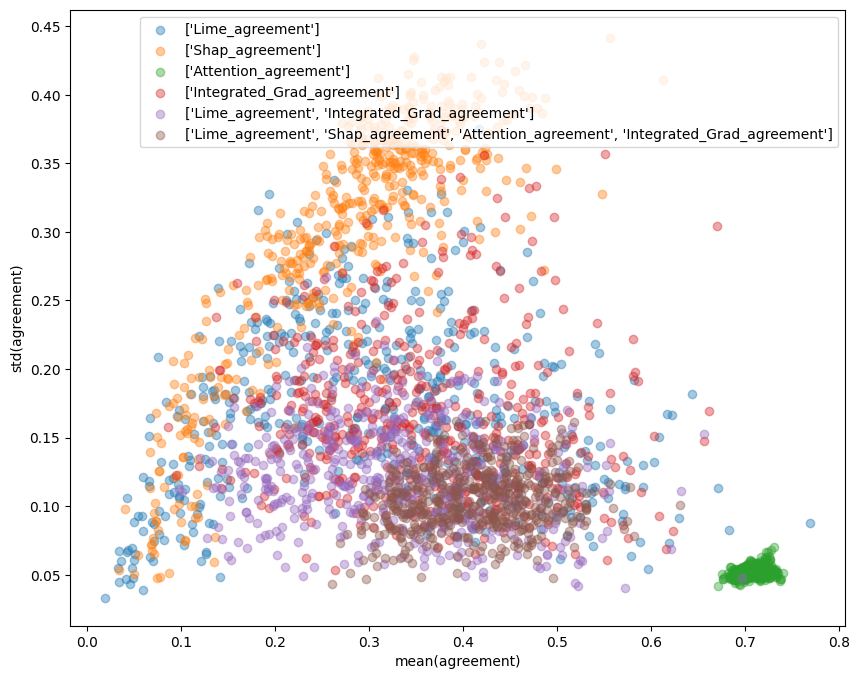

In [37]:
plt.figure(figsize=(10,8))
for mt in agreement_metrics:
    temp = df[['Test_example']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
     
    stds = temp.groupby('Test_example')['agreement'].std()
    means = temp.groupby('Test_example')['agreement'].mean()

    plt.scatter(x = means, y = stds, label = mt, alpha = 0.4)
    plt.xlabel('mean(agreement)')
    plt.ylabel('std(agreement)')
    plt.legend()

### 2D Agreement plots for specific examples

In [38]:


def simil(a, b, simil_type = 'cosine'):
    if simil_type == 'cosine':
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif simil_type == 'dot':
        return np.dot(a, b)
    
# These examples are hatespeech, where our inter ensemble gets it right and majority baseline gets it wrong
np.where(((all_ensemble_preds['True Label'] == 1) & (all_ensemble_preds['Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_modal_vote'] > 0.5) & (all_ensemble_preds['majority_baseline'] < 0.5)))

(array([508]),)

In [39]:
# Which example shall we look at?
idx = 508 # 98 is a good one for hate speech dev, 256 good one for COLA dev

simil_type = 'cosine' # 'cosine' or 'dot'

Interpretability ensemble modal vote takes the following model: cola_roberta_rand_3_test


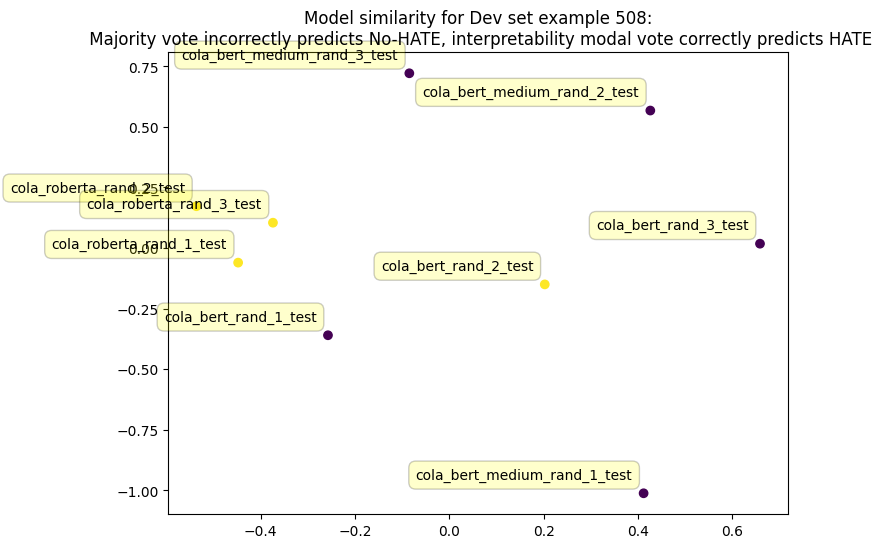

In [40]:
this_example = df[df['Test_example'] == idx].copy()

lime_scores = this_example['Lime_unified'].values
shap_scores = this_example['Shap_unified'].values + 1e-8
attn_scores = this_example['Attention_unified'].values
intg_scores = this_example['Integrated_Grad_unified'].values

lime_agreement = np.array([[simil(a, b, simil_type) for b in lime_scores] for a in lime_scores])
shap_agreement = np.array([[simil(a, b, simil_type) for b in shap_scores] for a in shap_scores])
attn_agreement = np.array([[simil(a, b, simil_type) for b in attn_scores] for a in attn_scores])
intg_agreement = np.array([[simil(a, b, simil_type) for b in intg_scores] for a in intg_scores])

#dist_matrix = (1 - lime_agreement) + (1 - shap_agreement) + (1 - attn_agreement) + (1 - intg_agreement)
dist_matrix = (1 - lime_agreement)

# convert distance matrix to 2D embedding
mds = manifold.MDS(n_components=2, dissimilarity="precomputed",
                   random_state=42, normalized_stress = 'auto')
results = mds.fit(dist_matrix)
coords = results.embedding_

# plot the result
fix, axs = plt.subplots(figsize = (8,6))
axs.scatter(coords[:, 0], coords[:, 1], marker = 'o', c = this_example['Predicted Label'])#, s = (4 - dist_matrix).sum(axis=0))
#plt.legend()
plt.title(f'Model similarity for Dev set example {idx}:\n Majority vote incorrectly predicts No-HATE, interpretability modal vote correctly predicts HATE')
for label, x, y in zip(this_example['Model_id'], coords[:, 0], coords[:, 1]):
    plt.annotate(
        label[:-1] + label[-1],
        xy = (x, y), xytext = (-8, 8),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.2))

chosen_inter_model = this_example['Model_id'].values[dist_matrix.sum(axis=0).argmin()]
print(f"Interpretability ensemble modal vote takes the following model: {chosen_inter_model}")

<Axes: >

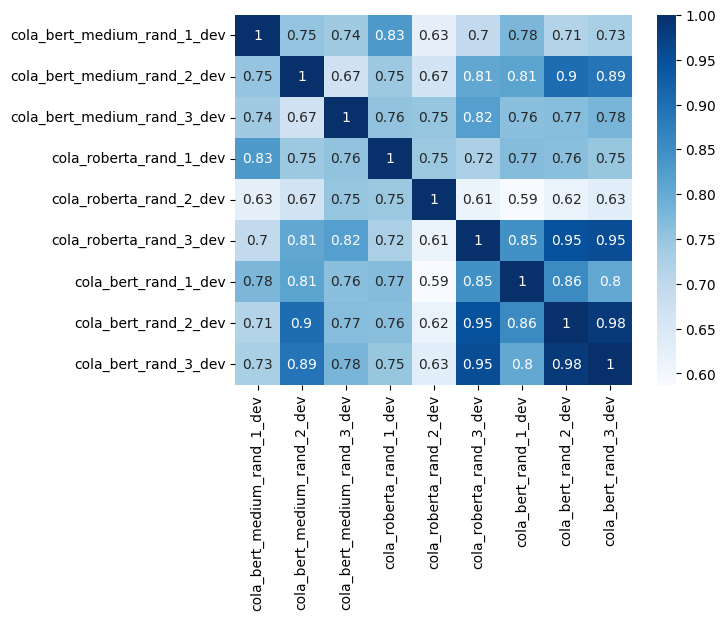

In [18]:


sns.heatmap((4 - dist_matrix)/4,
            xticklabels = this_example['Model_id'], yticklabels = this_example['Model_id'],
            cmap='Blues', annot=True)

In [19]:
' '.join(this_example['Tokens_unified'].values[0])

'<sos> they were taking a hard look at possible fta. <eos>'

In [23]:
from captum.attr import visualization as viz

toks = ['this', 'is', 'example', 'sentence']
interpretability = [-0.1, 0.2, -5, 4]

viz.visualize_text([viz.VisualizationDataRecord(word_attributions = interpretability,
                                                pred_prob = 0,  # this is irrelevant
                                                pred_class = 0, # this is irrelevant
                                                true_class = 0, # this is irrelevant
                                                attr_class = 0, # this is irrelevant
                                                attr_score = 0, # this is irrelevant
                                                raw_input_ids = toks,
                                                convergence_score = 0)])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,this is example sentence


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,this is example sentence
